In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd drive/My\Drive/LELSD/notebooks

/content/drive/MyDrive/LELSD/notebooks


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os
# import streamlit as st
import torch

import sys

sys.path.append("../")
import models
from lelsd import LELSD
from spaceUtils import *
import cv2
from tqdm import tqdm
import pandas as pd

import pickle
import io

plt.style.use('fivethirtyeight')

Load Gradient Maps and Semantic Masks

In [4]:
device = torch.device('cpu')
savePath = '../logs/'
L = 4

gradMaps = []
if device.type != 'cpu':

    with open('{}/ysCodes.pkl'.format(savePath), 'rb') as f:
        YS = pickle.load(f)
    with open('{}/rgbysCodes.pkl'.format(savePath), 'rb') as f:
        RGBYS = pickle.load(f)

    # LOAD GRADIENT MAPS
    # we have 100 images split in 10 batches 
    for b in range(10): 
        with open('{}/gradMapsS2/gradMapsB{}L{}.pkl'.format(savePath,b,L), 'rb') as f:
            gradmap = pickle.load(f)
        gradMaps += gradmap       

    # LOAD SEMANTIC MASKS
    with open('{}/maskS2/maskS2.pkl'.format(savePath), 'rb') as f:
        mask = pickle.load(f)
else:
    with open('{}/ysCodes.pkl'.format(savePath), 'rb') as f:
        YS = CPU_Unpickler(f).load()
    with open('{}/rgbysCodes.pkl'.format(savePath), 'rb') as f:
        RGBYS = CPU_Unpickler(f).load()

    # LOAD GRADIENT MAPS
    # we have 100 images split in 10 batches 
    for b in range(2): 

        with open('{}/gradMapsS2/gradMapsB{}L{}.pkl'.format(savePath,b,L), 'rb') as f:
            gradmap = CPU_Unpickler(f).load()
        gradMaps += gradmap
    
    # LOAD SEMANTIC MASKS
    with open('{}/maskS2/maskS2.pkl'.format(savePath), 'rb') as f:
        semantic_masks = CPU_Unpickler(f).load()

semantic_masks = torch.stack(semantic_masks)

gradMaps = torch.stack(gradMaps)[None]        
gradMaps = gradMaps.permute(0, 1, 6, 2, 3, 4, 5)
gradMaps = gradMaps.reshape(gradMaps.shape[0], gradMaps.shape[1], gradMaps.shape[2],-1)

In [5]:
# Compute Metrics for ranking
SLayer    = computeIU(semantic_masks, gradMaps)
all_count = TopRate(SLayer)

layer index:  0


#### Visualization of scores computed

Intersection and Union values visualization 

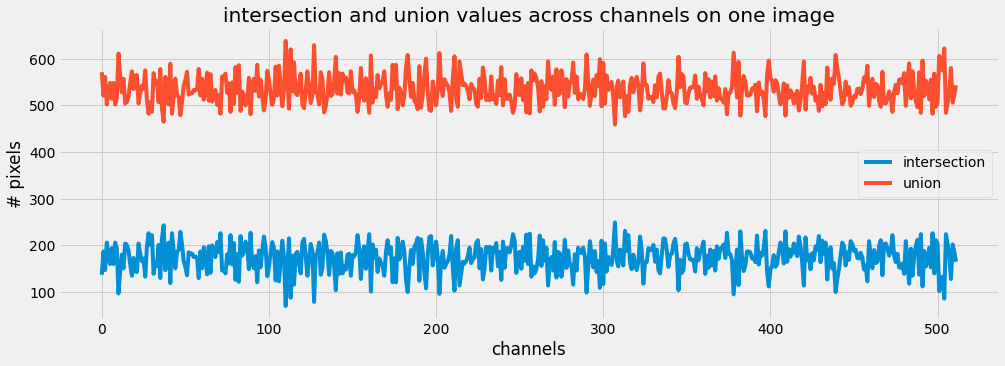

In [107]:
plt.figure(figsize=(15,5))

imIdx = 0
inter = SLayer[0][imIdx,:,part_to_mask_idx['hair'],0]
union = SLayer[0][imIdx,:,part_to_mask_idx['hair'],1]
plt.plot(inter,label='intersection')
plt.plot(union,label='union')

plt.title('intersection and union values across channels on one image')
plt.xlabel('channels')
plt.ylabel('# pixels')

plt.legend()
plt.show()

Counting metric

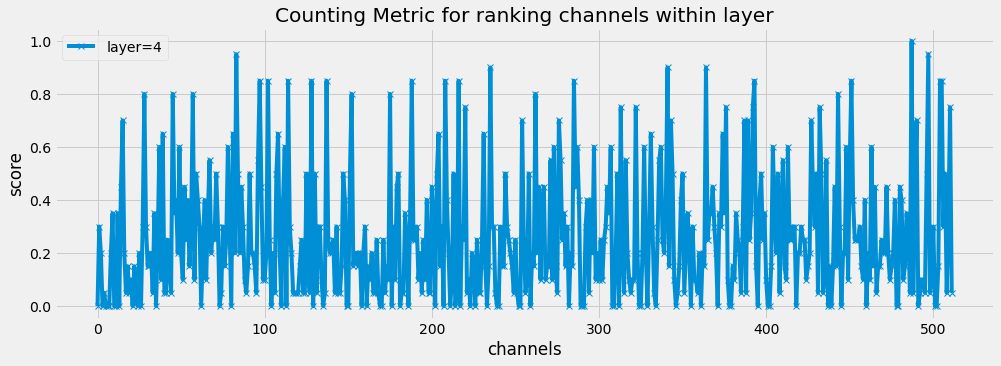

In [105]:
plt.figure(figsize=(15,5))
plt.plot(all_count[0][:,part_to_mask_idx['hair']], '-x', label='layer=4')
plt.title('Counting Metric for ranking channels within layer')
plt.xlabel('channels')
plt.ylabel('score')
plt.legend()
plt.show()

#### Best Channel finding

In [100]:
semantic = 'hair'
t = 10
channels = np.argsort(all_count[0][:,part_to_mask_idx[semantic]])[::-1][:t]
print("The top {} channels for {} in layer 4 are {}".format(t, semantic, channels))

The top 10 channels for hair in layer 4 are [487  83 497 235 341 364 137 188 285 393]
